# Bayesian Hierarchical Linear Regression

**Disclaimer** This notebook is an adaptation of [Bayesian Hierarchical Linear Regression](https://github.com/pyro-ppl/numpyro/blob/a66391dfed461fc48d6b082b10c76a1c1d75a9af/notebooks/source/bayesian_hierarchical_linear_regression.ipynb) implemented in NumPyro. 

Original author in NumPyro is [Carlos Souza](mailto:souza@gatech.edu). Updated by [Chris Stoafer](cstoafer@gmail.com) in NumPyro. Adapted to RxInfer by Dmitry Bagaev.

In [3]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


Probabilistic Machine Learning models can not only make predictions about future data but also model uncertainty. In areas such as personalized medicine, there might be a large amount of data, but there is still a relatively small amount available for each patient. To customize predictions for each person, it becomes necessary to build a model for each individual — considering its inherent uncertainties — and then couple these models together in a hierarchy so that information can be borrowed from other similar individuals [1].

The purpose of this tutorial is to demonstrate how to implement a Bayesian Hierarchical Linear Regression model using NumPyro. To provide motivation for the tutorial, I will use the [OSIC Pulmonary Fibrosis Progression competition](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression), hosted on Kaggle.

In [4]:
using DataFrames, Plots, CSV, StatsPlots

In [5]:
# https://www.machinelearningplus.com/linear-regression-in-julia/
# https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_hierarchical_linear_regression.ipynb

# Understanding the Task

Pulmonary fibrosis is a disorder characterized by scarring of the lungs, and its cause and cure are currently unknown. In this competition, the objective was to predict the severity of decline in lung function for patients. Lung function is assessed based on the output from a spirometer, which measures the forced vital capacity (FVC), representing the volume of air exhaled.

In medical applications, it is valuable to evaluate a model's confidence in its decisions. As a result, the metric used to rank the teams was designed to reflect both the accuracy and certainty of each prediction. This metric is a modified version of the Laplace Log Likelihood (further details will be provided later).

Now, let's explore the data and delve deeper into the problem involved.

In [7]:
train = CSV.read("data/osic_pulmonary_fibrosis.csv", DataFrame);

In [9]:
describe(train)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Patient,,ID00007637202177411956430,,ID00426637202313170790466,0,String31
2,Weeks,31.8618,-5,28.0,133,0,Int64
3,FVC,2690.48,827,2641.0,6399,0,Int64
4,Percent,77.6727,28.8776,75.6769,153.145,0,Float64
5,Age,67.1885,49,68.0,88,0,Int64
6,Sex,,Female,,Male,0,String7
7,SmokingStatus,,Currently smokes,,Never smoked,0,String31


In [8]:
first(train, 5)

Row,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
,String31,Int64,Int64,Float64,Int64,String7,String31
1,ID00007637202177411956430,-4,2315,58.2536,79,Male,Ex-smoker
2,ID00007637202177411956430,5,2214,55.7121,79,Male,Ex-smoker
3,ID00007637202177411956430,7,2061,51.8621,79,Male,Ex-smoker
4,ID00007637202177411956430,9,2144,53.9507,79,Male,Ex-smoker
5,ID00007637202177411956430,11,2069,52.0634,79,Male,Ex-smoker


The dataset provided us with a baseline chest CT scan and relevant clinical information for a group of patients. Each patient has an image taken at Week = 0, and they undergo numerous follow-up visits over approximately 1-2 years, during which their Forced Vital Capacity (FVC) is measured. For the purpose of this tutorial, we will only consider the Patient ID, the weeks, and the FVC measurements, discarding all other information. Restricting our analysis to these specific columns allowed our team to achieve a competitive score, highlighting the effectiveness of Bayesian hierarchical linear regression models, especially when dealing with uncertainty, which is a crucial aspect of the problem.

In [9]:
function get_patient(dataset, patient_id)
    return filter(:Patient => ==(patient_id), dataset)
end

function chart_patient(dataset, patient_id)
    data = get_patient(dataset, patient_id)
    x = data[!, "Weeks"]
    y = data[!, "FVC"]
    return scatter(x, y, title = patient_id, legend = false, xlabel = "Weeks", ylabel = "FVC")
end

chart_patient (generic function with 1 method)

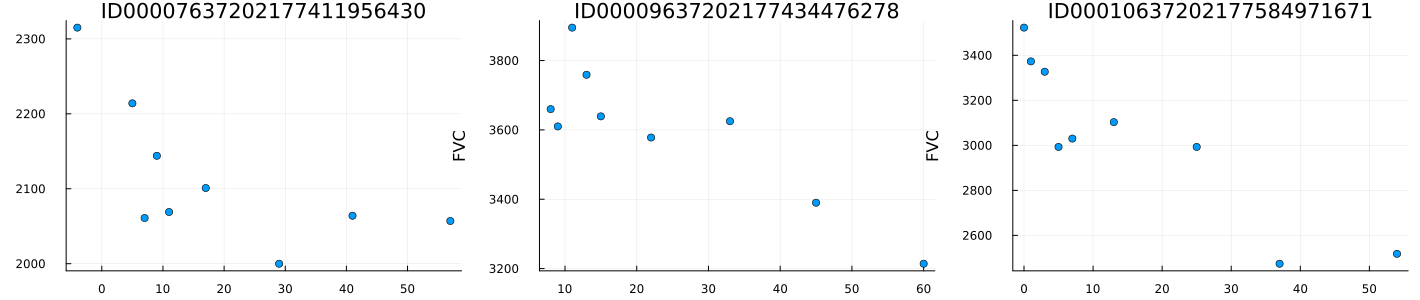

In [10]:
p1 = chart_patient(train, "ID00007637202177411956430")
p2 = chart_patient(train, "ID00009637202177434476278")
p3 = chart_patient(train, "ID00010637202177584971671")

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1420, 300))

# 2. Modelling: Bayesian Hierarchical Linear Regression with Partial Pooling

In [11]:
using RxInfer

[ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7]


In [12]:
@model function unpooled(patient_code, Weeks)
    μ_α ~ Normal(mean = 0.0, var = 250000.0)
    σ_α ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0
    μ_β ~ Normal(mean = 0.0, var = 250000.0)
    σ_β ~ Gamma(shape = 1.75, scale = 1.36) # Corresponds to half-normal with scale 3.0

    n_codes = length(patient_code)
    n_patients = length(unique(patient_code))

    α = randomvar(n_patients)
    β = randomvar(n_patients)

    for i in 1:n_patients
        α[i] ~ Normal(mean = μ_α, precision = σ_α)
        β[i] ~ Normal(mean = μ_β, precision = σ_β)
    end

    σ ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0

    FVC_est = randomvar(n_codes)
    data = datavar(Int, n_codes)

    for i in 1:n_codes
        FVC_est[i] ~ α[patient_code[i]] + β[patient_code[i]] * Weeks[i]
        data[i] ~ Normal(mean = FVC_est[i], precision = σ)
    end
    
end

@constraints function unpooled_constraints()
    q(μ_α, σ_α, μ_β, σ_β, σ) = q(μ_α)q(σ_α)q(μ_β)q(σ_β)q(σ)
    q(μ_α, σ_α, α) = q(μ_α, α)q(σ_α)
    q(μ_β, σ_β, β) = q(μ_β, β)q(σ_β)
    q(FVC_est, σ) = q(FVC_est)q(σ) 
end

unpooled_constraints (generic function with 1 method)

In [13]:
patient_ids = train[!, "Patient"]

encoder = Dict(map(enumerate(unique(values(patient_ids)))) do (code, patient_id)
    return patient_id => code
end)

patient_code = map(id -> encoder[id], patient_ids)
FVC_obs = values(train[!, "FVC"])
Weeks = values(train[!, "Weeks"]);

In [91]:
@time results = inference(
    model = unpooled(patient_code, Weeks),
    data = (data = FVC_obs, ),
    options = (limit_stack_depth = 500, ),
    constraints = unpooled_constraints(),
    initmessages = (
        α = vague(NormalMeanVariance),
        β = vague(NormalMeanVariance),
    ),
    initmarginals = (
        α = vague(NormalMeanVariance),
        β = vague(NormalMeanVariance),
        σ = Gamma(1.75, 45.54),
        σ_α = Gamma(1.75, 45.54),
        σ_β = Gamma(1.75, 1.36),
    ),
    returnvars = KeepLast(),
    iterations = 100,
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  3.154498 seconds (14.94 M allocations: 586.902 MiB, 11.58% gc time, 6.46% compilation time)


Inference results:
  Posteriors       | available for (α, σ_α, σ_β, σ, FVC_est, μ_β, μ_α, β)


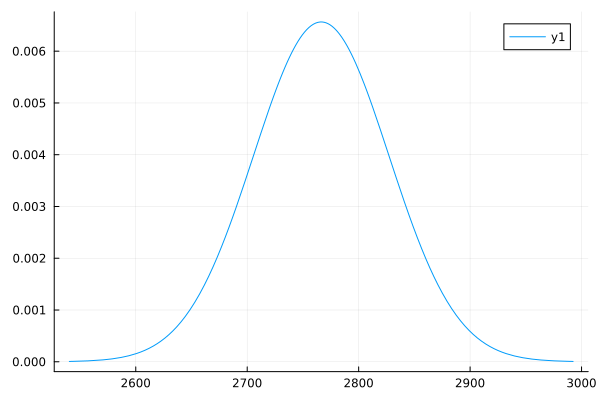

In [106]:
plot(Normal(mean_std(results.posteriors[:μ_α])...))

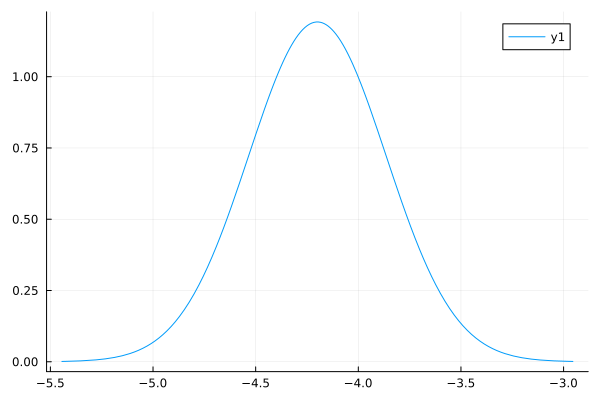

In [107]:
plot(Normal(mean_std(results.posteriors[:μ_β])...))

In [96]:
function chart_patient_with_predictions(results, dataset, encoder, patient_id; nsamples = 1000)
    p = chart_patient(dataset, patient_id)
    patient_code_id = encoder[patient_id]
    patient_weeks = get_patient(dataset, patient_id)[!, "Weeks"]
    patient_α = results.posteriors[:α][patient_code_id]
    patient_β = results.posteriors[:β][patient_code_id]
    
    predict_weeks = collect(range(-12, 134))

    predicted = map(predict_weeks) do week
        pm = mean(patient_α) + mean(patient_β) * week
        pv = var(patient_α) + var(patient_β) * week ^ 2
        return pm, sqrt(pv)
    end
    
    return plot!(p, predict_weeks, getindex.(predicted, 1), ribbon = getindex.(predicted, 2))
end

chart_patient_with_predictions (generic function with 1 method)

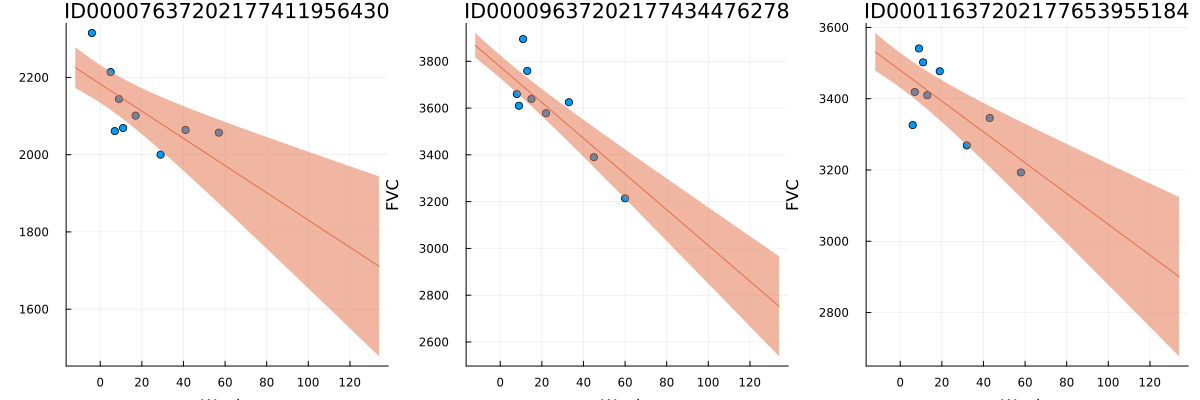

In [97]:
p1 = chart_patient_with_predictions(results, train, encoder, "ID00007637202177411956430")
p2 = chart_patient_with_predictions(results, train, encoder, "ID00009637202177434476278")
p3 = chart_patient_with_predictions(results, train, encoder, "ID00011637202177653955184")

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1200, 400))

In [19]:
FVC_pred = broadcast(results.posteriors[:FVC_est], Ref(results.posteriors[:σ])) do f, s
    return @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ = f, q_τ = s)
end

rmse = mean((train[!, "FVC"] .- mean.(FVC_pred)) .^ 2) ^ (1/2)

println("RMSE $rmse")

sigma_c = std.(FVC_pred)
sigma_c[sigma_c .< 70] .= 70
delta = abs.(mean.(FVC_pred) .- train[!, "FVC"])
delta[delta .> 1000] .= 1000
lll = mean(-sqrt(2) .* delta ./ sigma_c .- log.(sqrt(2) .* sigma_c))
println("Laplace Log Likelihood: $lll")

RMSE 124.00689822787754
Laplace Log Likelihood: -6.156784143862489


In [32]:
DataFrames.describe(train, cols = [ "SmokingStatus" ])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Nothing,String31,Nothing,String31,Int64,DataType
1,SmokingStatus,,Currently smokes,,Never smoked,0,String31


In [61]:
smoking_ids = Dict(map(enumerate(unique(train[!, "SmokingStatus"]))) do (code, smoking_status)
    return smoking_status => code
end)

smoking_encoder = Dict(map(unique(values(patient_ids))) do patient_id
    smoking_status = first(unique(get_patient(train, patient_id)[!, "SmokingStatus"]))
    return encoder[patient_id] => smoking_ids[smoking_status]
end)

smoking_status_code = map(id -> smoking_encoder[id], 1:length(unique(patient_ids)));

In [64]:
@model function unpooled_with_smoking(patient_code, smoking_status_code, Weeks)
    μ_α_global ~ Normal(mean = 0.0, var = 250000.0)
    σ_α_global ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0
    μ_β_global ~ Normal(mean = 0.0, var = 250000.0)
    σ_β_global ~ Gamma(shape = 1.75, scale = 1.36) # Corresponds to half-normal with scale 3.0

    n_codes = length(patient_code)
    n_smoking_statuses = length(unique(smoking_status_code))
    n_patients = length(unique(patient_code))

    μ_α_smoking_status = randomvar(n_smoking_statuses)
    μ_β_smoking_status = randomvar(n_smoking_statuses)
    
    for i in 1:n_smoking_statuses
        μ_α_smoking_status[i] ~ Normal(mean = μ_α_global, precision = σ_α_global)
        μ_β_smoking_status[i] ~ Normal(mean = μ_β_global, precision = σ_β_global)
    end
    
    α = randomvar(n_patients)
    β = randomvar(n_patients)

    for i in 1:n_patients
        α[i] ~ Normal(mean = μ_α_smoking_status[smoking_status_code[i]], precision = σ_α_global)
        β[i] ~ Normal(mean = μ_β_smoking_status[smoking_status_code[i]], precision = σ_β_global)
    end

    σ ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0

    FVC_est = randomvar(n_codes)
    data = datavar(Int, n_codes)

    for i in 1:n_codes
        FVC_est[i] ~ α[patient_code[i]] + β[patient_code[i]] * Weeks[i]
        data[i] ~ Normal(mean = FVC_est[i], precision = σ)
    end
    
end

@constraints function unpooled_with_smooking_constraints()
    q(μ_α_global, σ_α_global, μ_β_global, σ_β_global) = q(μ_α_global)q(σ_α_global)q(μ_β_global)q(σ_β_global)
    q(μ_α_smoking_status, μ_β_smoking_status, σ_α_global, σ_β_global) = q(μ_α_smoking_status)q(μ_β_smoking_status)q(σ_α_global)q(σ_β_global)
    q(μ_α_global, σ_α_global, μ_β_global, σ_β_global, σ) = q(μ_α_global)q(σ_α_global)q(μ_β_global)q(σ_β_global)q(σ)
    q(μ_α_global, σ_α_global, α) = q(μ_α_global, α)q(σ_α_global)
    q(μ_β_global, σ_β_global, β) = q(μ_β_global, β)q(σ_β_global)
    q(FVC_est, σ) = q(FVC_est)q(σ) 
end

unpooled_with_smooking_constraints (generic function with 1 method)

In [67]:
@time results_with_smooking = inference(
    model = unpooled_with_smoking(patient_code, smoking_status_code, Weeks),
    data = (data = FVC_obs, ),
    options = (limit_stack_depth = 500, ),
    constraints = unpooled_with_smooking_constraints(),
    initmessages = (
        α = vague(NormalMeanVariance),
        β = vague(NormalMeanVariance),
    ),
    initmarginals = (
        σ = Gamma(1.75, 45.54),
        σ_α_global = Gamma(1.75, 45.54),
        σ_β_global = Gamma(1.75, 1.36),
    ),
    returnvars = KeepLast(),
    iterations = 100,
    showprogress = true
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  3.097011 seconds (15.00 M allocations: 590.261 MiB, 10.72% gc time, 7.27% compilation time)


Inference results:
  Posteriors       | available for (α, σ_α_global, μ_α_smoking_status, σ, FVC_est, μ_α_global, β, μ_β_global, σ_β_global, μ_β_smoking_status)


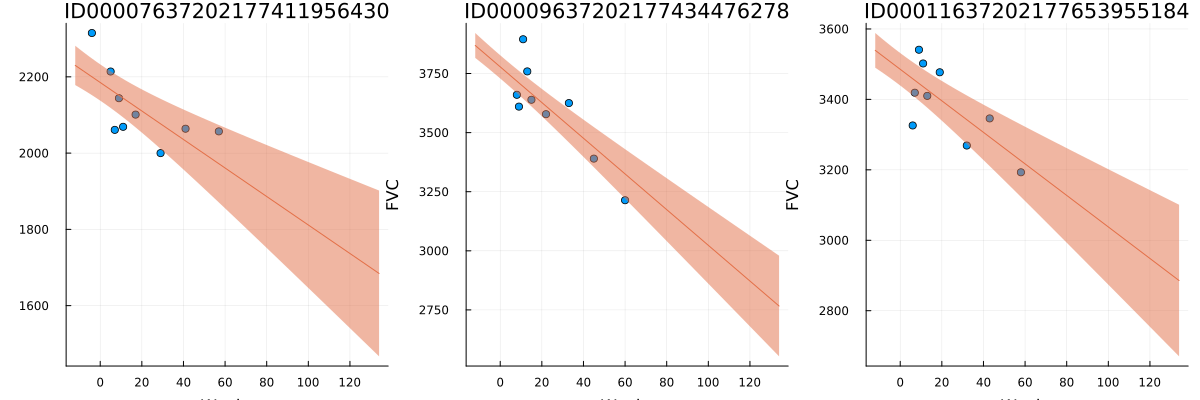

In [68]:
p1 = chart_patient_with_predictions(results_with_smooking, train, encoder, "ID00007637202177411956430") # Never smoked
p2 = chart_patient_with_predictions(results_with_smooking, train, encoder, "ID00009637202177434476278") # Ex-smoker
p3 = chart_patient_with_predictions(results_with_smooking, train, encoder, "ID00011637202177653955184") # Currently smokes

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1200, 400))

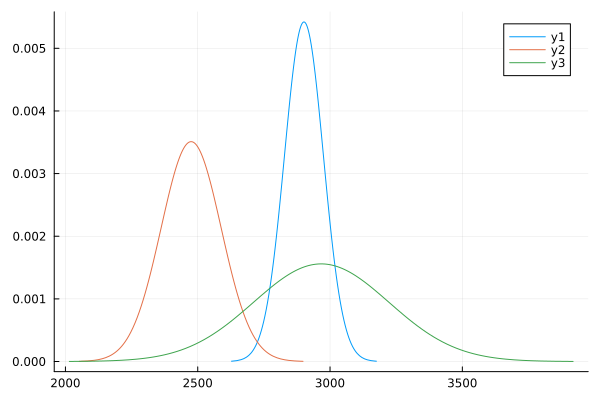

In [103]:
plot(map(d -> Normal(mean_std(d)...), results_with_smooking.posteriors[:μ_α_smoking_status]))

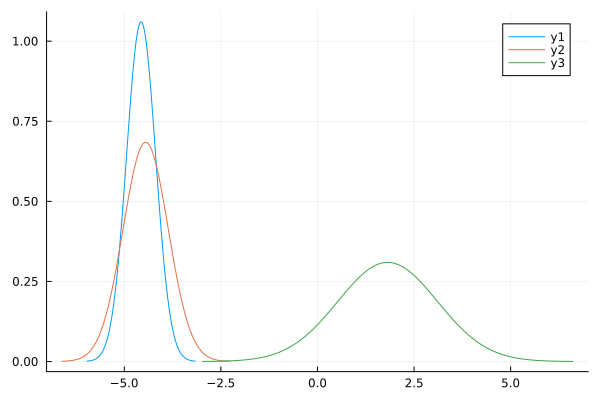

In [104]:
plot(map(d -> Normal(mean_std(d)...), results_with_smooking.posteriors[:μ_β_smoking_status]))

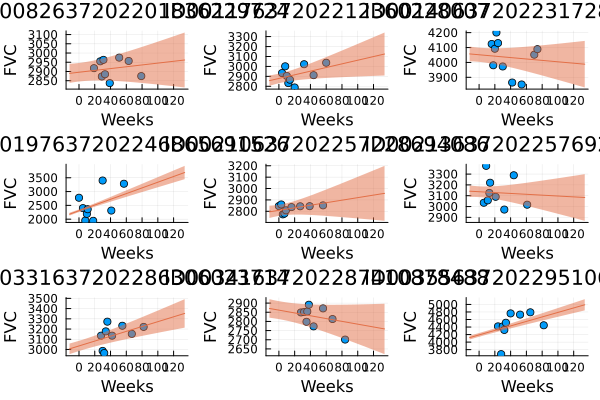

In [73]:
plots = []

for (i, patient) in enumerate(unique(filter(:SmokingStatus => ==("Currently smokes"), train)[!, "Patient"]))
    push!(plots, chart_patient_with_predictions(results_with_smooking, train, encoder, patient))
end

plot(plots...)

In [74]:
FVC_pred_smoking = broadcast(results_with_smooking.posteriors[:FVC_est], Ref(results_with_smooking.posteriors[:σ])) do f, s
    return @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ = f, q_τ = s)
end

rmse_smoking = mean((train[!, "FVC"] .- mean.(FVC_pred_smoking)) .^ 2) ^ (1/2)

println("RMSE $rmse_smoking")

sigma_c_smoking = std.(FVC_pred_smoking)
sigma_c_smoking[sigma_c_smoking .< 70] .= 70
delta_smoking = abs.(mean.(FVC_pred_smoking) .- train[!, "FVC"])
delta_smoking[delta_smoking .> 1000] .= 1000
lll_smoking = mean(-sqrt(2) .* delta_smoking ./ sigma_c_smoking .- log.(sqrt(2) .* sigma_c_smoking))
println("Laplace Log Likelihood: $lll_smoking")

RMSE 124.78459808665629
Laplace Log Likelihood: -6.165346437287973
